# STEP 1. Patient Segmentation 

- step 1a. define the patients( who they're aka feature)
- step 1b. define the patients sessions

#### These are all necessary libraries for:

- Data processing (pandas, numpy, sklearn)

- Preprocessing (Pipeline, Imputer, Scaler)

- Clustering (DBSCAN, KMeans)

- Dimensionality reduction (PCA, TSNE)

- Plotting (matplotlib)



In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os

# Define the path where you saved the processed CSVs
data_path = r"C:\Users\kaoth\OneDrive\Desktop\Data Science Lectures\Machine Learning\Amdari Internship\medoptix-ai-internship\medoptix_data\processed"

# Load each dataset
patients_df = pd.read_csv(os.path.join(data_path, "patients.csv"))
sessions_df = pd.read_csv(os.path.join(data_path, "sessions.csv"))
feedback_df = pd.read_csv(os.path.join(data_path, "feedback.csv"))
clinics_df = pd.read_csv(os.path.join(data_path, "clinics.csv"))
interventions_df = pd.read_csv(os.path.join(data_path, "interventions.csv"))
dropout_df = pd.read_csv(os.path.join(data_path, "dropout_flags.csv"))

# Quick check
print("Patients:", patients_df.shape)
print("Sessions:", sessions_df.shape)
print("Feedback:", feedback_df.shape)
print("Clinics:", clinics_df.shape)
print("Interventions:", interventions_df.shape)
print("Dropout Flags:", dropout_df.shape)


Patients: (5000, 12)
Sessions: (70236, 10)
Feedback: (49165, 4)
Clinics: (8, 9)
Interventions: (5016, 6)
Dropout Flags: (5000, 3)


In [4]:
# step 1b --- Define the sessions the patients had in relations to the therapy (EXTRA FEATURE ENGINEERING)-- Dynamic dataset

# Ensure sessions_df has "week" column derived from date
sessions_df['date'] = pd.to_datetime(sessions_df['date'])
sessions_df['week'] = sessions_df['date'].dt.isocalendar().week

sess_agg = (
    sessions_df
    .sort_values(['patient_id', 'date'])
    .assign(pain_delta=lambda d: d.groupby("patient_id")["pain_level"].diff())
    .groupby("patient_id")
    .agg(
        n_sessions=("session_id", "count"),
        avg_session_duration=("duration", "mean"),
        first_week=("week", "min"),
        last_week=("week", "max"),
        mean_pain=("pain_level", "mean"),
        mean_pain_delta=("pain_delta", "mean")
        # Optional: Add more if 'home_adherence_pc' or 'satisfaction' exist
    )
)

sess_agg.head(3)

,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta
patient_id,,,,,,
1,20,41.750000,18,29,2.150000,-0.263158
2,8,33.875000,4,52,2.250000,-0.571429
3,17,41.470588,1,51,2.470588,-0.312500


#### Interpretation

- n_sessions: Total number of sessions attended by the patient.
- avg_session_duration: Average duration of their sessions.
- first_week: The week number of their first session.
- last_week: The week number of their last session.
- mean_pain: Average pain level reported across sessions.
- mean_pain_delta: Average change in pain level between sessions.

In [13]:
# step 1c Define the patients (static dataset)
pat_sel = patients_df.set_index("patient_id")

pat_sel.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type
patient_id,,,,,,,,,,,
172,66,Male,17.9,False,NaN,Shoulder,2024-12-15 00:12:44.286283,Self-Referral,True,1,Public
173,70,Female,25.2,False,NaN,Hip,2024-07-03 00:12:44.286283,Self-Referral,True,1,Private-Top-Up
174,48,Female,22.2,False,NaN,Back,2025-04-16 00:12:44.286283,Self-Referral,True,5,Private-Top-Up


In [16]:
# step 1d -- join static dataset + dynamice (Behvaioral features)

X_raw = pat_sel.join(sess_agg, how="left")
X_raw.head(3)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta
patient_id,,,,,,,,,,,,,,,,,
172,66,Male,17.9,False,NaN,Shoulder,2024-12-15 00:12:44.286283,Self-Referral,True,1,Public,12,38.583333,1,52,1.833333,-0.363636
173,70,Female,25.2,False,NaN,Hip,2024-07-03 00:12:44.286283,Self-Referral,True,1,Private-Top-Up,16,41.750000,27,38,2.187500,-0.333333
174,48,Female,22.2,False,NaN,Back,2025-04-16 00:12:44.286283,Self-Referral,True,5,Private-Top-Up,14,42.000000,16,27,1.500000,-0.153846




This table provides a comprehensive view of each patient's characteristics and their therapy engagement, which is useful for further analysis, clustering, or predictive modeling.

In [17]:
# step 1e Label engineering & encoding 

# patient static attributes ----- define what describes a patient
pat_sel = patients_df[
    [
        "patient_id",
        "age",
        "gender",
        "bmi",
        "smoker",
        "chronic_cond",
        "injury_type",
        "referral_source",
        "insurance_type"
    ]
].set_index("patient_id")


# label engineering (attach the drop out flags to the patient)
# use labels as your source of truth which we'd later use in prediction (who dropped out or not)
label = dropout_df.set_index("patient_id").dropout 

In [18]:
X_raw.head(2)

,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,n_sessions,avg_session_duration,first_week,last_week,mean_pain,mean_pain_delta
patient_id,,,,,,,,,,,,,,,,,
172,66,Male,17.9,False,NaN,Shoulder,2024-12-15 00:12:44.286283,Self-Referral,True,1,Public,12,38.583333,1,52,1.833333,-0.363636
173,70,Female,25.2,False,NaN,Hip,2024-07-03 00:12:44.286283,Self-Referral,True,1,Private-Top-Up,16,41.750000,27,38,2.187500,-0.333333


In [19]:
#step 1f  Data Pipeline --- compress all your data preprocessing step into one pipeline 

# step 1f-i -- Define your numeric columns and Categorical columns (non-numeric)


# looking out for high dimensions in your data 
# looking out for  density of your data
num_col = [                                  # manual dimension reduction is as a result of your correlation analyis
    "age", "bmi",
    "n_sessions", "avg_session_duration",
    "mean_pain", "mean_pain_delta"
]

cat_col = [
    "gender", "smoker",
    "chronic_cond", "injury_type"
]

X_raw[cat_col].astype("string")  # casting categorical data

,gender,smoker,chronic_cond,injury_type
patient_id,,,,
172,Male,False,<NA>,Shoulder
173,Female,False,<NA>,Hip
174,Female,False,<NA>,Back
175,Female,False,<NA>,Knee
176,Male,False,<NA>,Neck
...,...,...,...,...
4996,Female,True,Diabetes,Back
4997,Female,False,<NA>,Shoulder
4998,Female,False,<NA>,Back


In [20]:
# step 1g - Preprocessing with the pipeline 
# Numeric features: Missing values → median, then scaled.
# Categorical: Missing values → mode, then one-hot encoded.


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scalar", RobustScaler())
    ]
)



categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onhot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)


In [21]:
#### Column Transformer 
# ColumnTransformer applies each to their respective columns.

preproc = ColumnTransformer(
    transformers= [
        ("num", numeric_pipe, num_col),
        ("cat", categorical_pipe, cat_col)
    ]
)

print(type(preproc))

<class 'sklearn.compose._column_transformer.ColumnTransformer'>


In [22]:
# model our data
X_clean = preproc.fit_transform(X_raw)

In [23]:
# auto dimension reduction 
# PCA to help us retain the variance of our features 
pca = PCA(n_components=0.85, random_state=45)

X_reduced = pca.fit_transform(X_clean)

### step h:  clustering
 - define K-means
 
 - ELbow 
 - silhouette
 - choose K & get your cluster
 - DBSCAN & t-SNE plot
 - PCA --- 2D dimensional overview of our clusters
 - Answer Dropout question ("fast_imporver", "steady progresser", "frustrated_droppers")

In [24]:
# DBSCAN 
# Applying DBSCAN to our cleaned data

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np


# define our DBSCAN algorithm
eps = 1.5     # whats the distance between each patient in a cluster should be
min_samples =3          # define the minimum number of border points
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_reduced)
db_labels = db.labels_


# filtered valid points or clusters (excluded the noise points)
valid_labels = db_labels != -1



# Rule of thumb : 
# silhoutee score  should be between 1, 0 or -1 
# if your score is above 0 and close to 1 ----- cluster is in a very good shape
# if your score is 0 ---- cluster good but could be improved 
# if your score is less than 0 ---- the cluster is not in a good shape

# calculate the silhoutee score
##checking to see based on our eps/min_samples can we get a cluster out of our data?
# make sure or ensure when you fina atleast one cluster : give us the silhoutee score
if valid_labels.sum() > 1 :                      
    sil_db = silhouette_score(X_reduced[valid_labels], db_labels[valid_labels])
    print(f"DBSCAN VALID-CLUSTER Silhoutee score {sil_db:.3f}")
else:
    print("Not enought cluster to be derived")


DBSCAN VALID-CLUSTER Silhoutee score 0.441


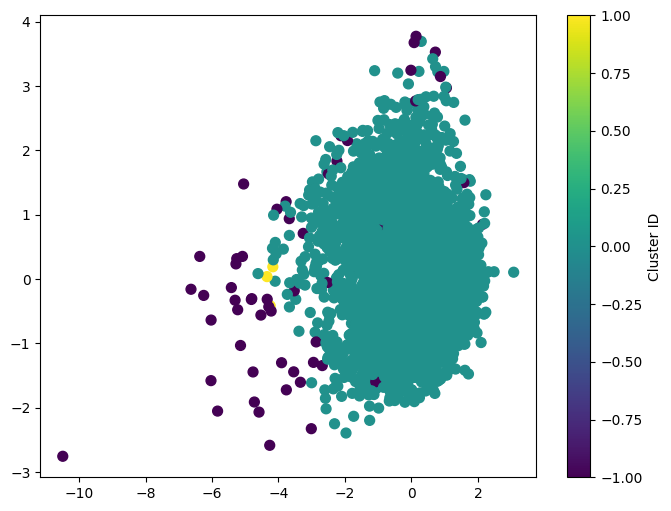

In [25]:
# plot DBSCAN

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=db_labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster ID')


##### define our k 

- group the patients into meaningful persona

    - step h-i ---- loop through a range of k (assumptions)
    - step h-ii ---- plotting the elbow 
    - step h-iii - plotting the silhoutee
    - step h-iv ---- decision making & choosing of k





In [26]:
# step h-1 : define a function (Search for K)
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
import  matplotlib.pyplot as plt

def k_search(X, k_range=range(2,11)):
    wcss, sils = [], []
    
    for k in k_range:                    # loop through the range of k
        km = KMeans(
            n_clusters= k,
            init = "k-means++",          # First centroid start start far apart 
            n_init= "auto",
            random_state= 42,
            algorithm = "lloyd",
        )
        preds = km.fit_predict(X)           # runs the algorithm & returns a cluster id for each patient
        wcss.append(km.inertia_)            # Elbows tension inside clusters  AKA rubber band effect 
        sils.append(silhouette_score(X, preds))  # Silhouteee hows seperate & compact each point is 
    return wcss, sils

Text(0, 0.5, 'WCSS')

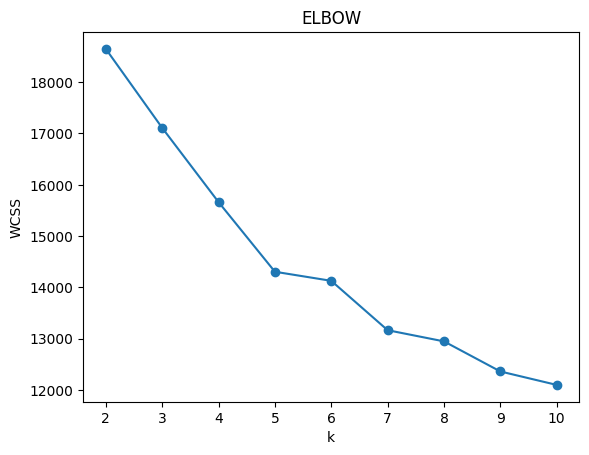

In [27]:
# step h-ii : Plot our elbow and silhouteee
wcss , sils = k_search(X_reduced)

plt.figure; plt.plot(range(2,11), wcss, 'o-')
plt.title("ELBOW")
plt.xlabel("k"); plt.ylabel("WCSS")

Text(0, 0.5, 'silhoutee score')

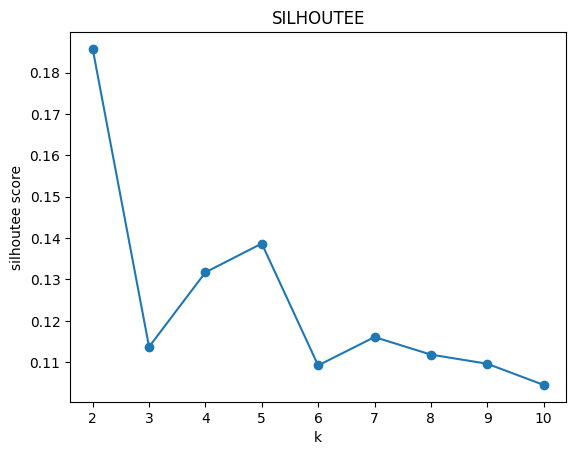

In [28]:
# step h-iii plotting the silhoutee

plt.figure; plt.plot(range(2,11),sils, 'o-')
plt.title("SILHOUTEE")
plt.xlabel("k"); plt.ylabel("silhoutee score")

###### Rule of thumb : pick the smallet k past the elbow and hwos silhoutee closer to the KPI (e.g business >=0.6)

In [29]:
# step h-iv Choose our k = 4

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


k_OPT = 3
k_means = KMeans(
    n_clusters=k_OPT, n_init="auto",
    random_state=42, algorithm="lloyd"
)
clusters = k_means.fit_predict(X_reduced)


In [ ]:
# # DBSCAN ---- catch any extra outliers 
# knn = NearestNeighbors(n_neighbors=4).fit(X_pre)
# dists = np.sort(knn.kneighbors(X_pre)[0][:,-1])

# plt.figure(); plt.plot(dists, 'o-'); plt.title("4-NN distance - choose E"); plt.show()

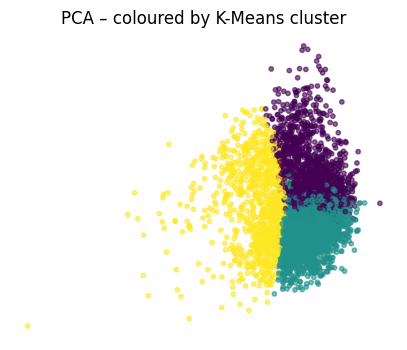

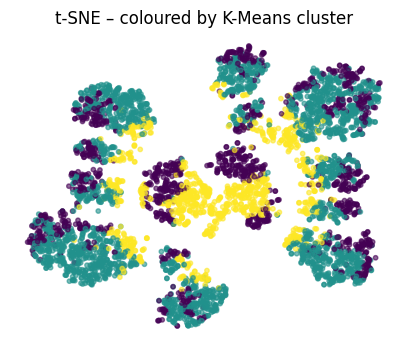

In [30]:
# ---------------- PCA / t-SNE visual -----------------------
from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE

pca2  = PCA(n_components=2, random_state=42).fit_transform(X_reduced)
tsne2 = TSNE(n_components=2, perplexity=40,
             init="pca", random_state=42).fit_transform(X_reduced)

def scatter_2d(mat, labels, title):
    plt.figure(figsize=(5, 4))
    plt.scatter(mat[:, 0], mat[:, 1], c=labels, alpha=0.6, s=10)
    plt.title(title); plt.axis("off")

scatter_2d(pca2,  clusters, "PCA – coloured by K-Means cluster")
scatter_2d(tsne2, clusters, "t-SNE – coloured by K-Means cluster")

In [32]:

# Step 1: Attach cluster labels back to the raw patient data
X_labeled = X_raw.copy()
X_labeled['cluster'] = clusters
X_labeled['dropout'] = label  # from dropout_df["dropout"]

# Step 2: Analyze the clusters
cluster_summary = X_labeled.groupby("cluster").agg({
    "mean_pain_delta": "mean",
    "n_sessions": "mean",
    "dropout": "mean",
    "avg_session_duration": "mean",
    "mean_pain": "mean"
}).round(2)

print(cluster_summary)


         mean_pain_delta  n_sessions  dropout  avg_session_duration  mean_pain
cluster                                                                       
0                  -0.23       13.59     0.02                 40.72       1.63
1                  -0.30       15.66     0.00                 38.81       2.06
2                  -0.50       10.77     0.05                 39.56       2.31


### Based on the table above:

## Cluster 0:
- Slight improvement in pain (-0.23).
- High session count (13.6) and low dropout (2%).
- Longest session durations (~41 mins).
- Lowest average pain (1.63).

👉 Interpretation: These are committed patients, attending many long sessions and already starting at a low pain level, so their improvement appears smaller.
🔖 Label suggestion: "Steady Progressors"

## Cluster 1:
- Moderate improvement in pain (-0.30).
- Highest number of sessions (15.7), zero dropout, and moderate duration.
- Moderate initial pain (2.06).

👉 Interpretation: Very engaged patients, highly consistent, fully compliant. Pain is decreasing steadily.
🔖 Label suggestion: "Fast Improvers"



## Cluster 2:
- Most pain improvement (-0.50) but with:
- Fewer sessions (10.8)
- Highest dropout rate (5%)
- Highest starting pain (2.31)

👉 Interpretation: These patients came in with more pain, showed biggest short-term gains, but didn’t stay long enough. Possibly dropped out due to early frustration or life constraints.
🔖 Label suggestion: "Frustrated Droppers"

In [35]:
cluster_map = {
    0: "Steady Progressors",
    1: "Fast Improvers",
    2: "Frustrated Droppers"
}


C:\Users\kaoth\AppData\Local\Temp\ipykernel_25264\417071300.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=X_labeled, x='persona', y='mean_pain_delta', ci=None)


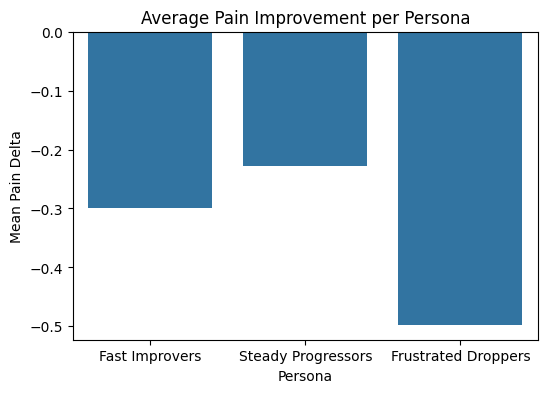

               persona  mean_pain_delta
0       Fast Improvers        -0.299482
1  Frustrated Droppers        -0.497821
2   Steady Progressors        -0.228343


In [43]:
# Bar Plot: Mean Pain Delta per Cluster
import seaborn as sns
import matplotlib.pyplot as plt


# Create a new column 'persona' with the mapped labels
X_labeled['persona'] = X_labeled['cluster'].map(cluster_map)

# Bar Plot: Mean Pain Delta per Persona
plt.figure(figsize=(6, 4))
sns.barplot(data=X_labeled, x='persona', y='mean_pain_delta', ci=None)
plt.title('Average Pain Improvement per Persona')
plt.ylabel('Mean Pain Delta')
plt.xlabel('Persona')

# Save the plot before showing it
plt.savefig("mean_pain_delta_by_persona.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Print mean_pain_delta values grouped by persona
print(X_labeled.groupby("persona")["mean_pain_delta"].mean().reset_index())



In [44]:
cluster_summary = X_labeled.groupby("cluster").agg({
    "mean_pain_delta": "mean",
    "n_sessions": "mean",
    "dropout": "mean",
    "avg_session_duration": "mean",
    "mean_pain": "mean"
}).reset_index()

cluster_summary['persona'] = cluster_summary['cluster'].map(cluster_map)

print(cluster_summary[['persona', 'mean_pain_delta', 'n_sessions', 'dropout']])


               persona  mean_pain_delta  n_sessions   dropout
0   Steady Progressors        -0.228343   13.585783  0.015038
1       Fast Improvers        -0.299482   15.658430  0.001196
2  Frustrated Droppers        -0.497821   10.771401  0.054475


### Patient Segmentation Personas – MedOptix Therapy Adherence Study

Through clustering analysis of patient therapy data, i identified three distinct patient personas that characterize adherence behavior and therapy outcomes:

- Steady Progressors
These patients show consistent, moderate improvement in pain levels over their therapy duration. They attend a high number of sessions (average ~14) and demonstrate a low dropout rate (~1.5%). Their gradual but steady progress suggests reliable engagement with the therapy program.

- Fast Improvers
This group experiences quicker reductions in pain and attends the highest number of sessions (~16). Remarkably, they exhibit an almost negligible dropout rate (~0.1%), indicating strong adherence and motivation. They represent the ideal therapy trajectory, with rapid gains and consistent participation.

- Frustrated Droppers
Although this group shows the most significant pain improvement per session, they attend fewer sessions (~11) and have the highest dropout rate (~5.4%). This suggests that while some progress is achieved early, challenges such as frustration or external factors may lead them to discontinue therapy prematurely.

### Implications:
Understanding these personas allows MedOptix to tailor personalized interventions—such as targeted nudges for the Frustrated Droppers to boost engagement, and reinforcement for Fast Improvers to maintain momentum—ultimately aiming to reduce dropout rates and improve patient outcomes across the board.

